In [1]:
import numpy as np
import torch

import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict
from gym.utils import seeding

import random

from agent import PPO
import os
import matplotlib.pyplot as plt

In [2]:
class Heater(Env):
    def __init__(self):

        self.done = False
        self.reward = 0
        self.max_time = 30

        # Action declaration
        self.action_space = Dict({
            "discrete": Discrete(3), # Discrete actions up, down, stay
            "continuous": Box(low=np.array([0., ]), high=np.array([1., ]), dtype=np.float32) 
        })

        # Temperature array
        self.low = np.array([0.,])
        self.high = np.array([100.,])
        self.observation_space = Box(low=self.low, high=self.high, dtype=np.float32)
        
        # Set start temp and start time
        self.reset()
    
    
    def seed(self,seed=None):
        self.np_random, seed = seeding.np_random(seed)

    def step(self, action):
        temp = self.state[0]

        d_action = action["discrete"]

        c_action = action["continuous"]
        c_action = self.interpolation(c_action)[0]
        
        if d_action == 0: # Increase temperature
            temp += c_action
        
        elif d_action == 1: # Decrease temperature
            temp -= c_action
        
        elif d_action == 2:
            temp += 0
        
        # Reward function

        if self.time > 0:
            self.reward -= abs(38.0 - temp) 
            
            if 37.5 <= temp <= 39.0:
                reward = 100
                self.done = True
            
            if abs(38.0 - temp) >= 20:
                reward = -100
                self.done = True

        # Reduce time by 1 second
        self.time -= 1 


        self.state = np.array([temp, ], dtype=np.float32)

        if self.time <= 0:
            self.done = True
            
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, self.reward, self.done, info
    
    def interpolation(self, x):
        # interpolation
        y1 = 0.
        y2 = 5.
        x1 = 0.
        x2 = 1.

        y = y1 + ((y2 - y1)/(x2 - x1))*(x-x1)
        return y

    def render(self):
        # Implement visualization --> in this case is not built
        pass
    
    def reset(self):
        # Reset shower temperature
        temp =  38. + random.randint(-5, 5)
        self.state = np.array([temp, ], dtype=np.float32)

        self.done = False
        self.reward = 0
        
        # Reset shower time
        self.time = self.max_time 
        return self.state


In [3]:
env = Heater()
episodes = 10

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    temps = []

    while not done:
        action = env.action_space.sample()  
        temp, reward, done, info = env.step(action)
        temps.append(temp) 
        score +=reward
    mean_temp = np.mean(np.array(temps))
    print(f'Episode: {episode}, Mean temperature: {mean_temp:.2f} Score: {score}')

Episode: 1, Mean temperature: 27.15 Score: -992.9589233398438
Episode: 2, Mean temperature: 30.82 Score: -3037.8352432250977
Episode: 3, Mean temperature: 44.83 Score: -2851.3600158691406
Episode: 4, Mean temperature: 37.50 Score: -60.79981994628906
Episode: 5, Mean temperature: 43.28 Score: -356.0576629638672
Episode: 6, Mean temperature: 38.72 Score: -0.71820068359375
Episode: 7, Mean temperature: 40.11 Score: -15.320335388183594
Episode: 8, Mean temperature: 38.67 Score: -0.6740226745605469
Episode: 9, Mean temperature: 38.24 Score: -0.24298858642578125
Episode: 10, Mean temperature: 29.49 Score: -3435.396915435791


c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


### Helper functions

In [4]:
def evaluate_policy(env, model, render, steps_per_epoch):
    scores = 0
    turns = 3
    for j in range(turns):
        s, done, ep_r, steps = env.reset(), False, 0, 0
        while not (done or (steps >= steps_per_epoch)):
            # Take deterministic actions at test time
            action_d, action_c = model.evaluate(s)
            action = {
                "discrete": action_d,
                "continuous": action_c 
            }
            s_prime, r, done, info = env.step(action)

            ep_r += r
            steps += 1
            s = s_prime
            if render:
                env.render()
        scores += ep_r
    return scores/turns


def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    
    plt.plot(x, running_avg, label="Running average")
    plt.plot(x, scores, alpha=0.4)
    plt.title('Learning plot')
    plt.xlabel("Runs")
    plt.ylabel("Scores")
    plt.legend(loc="best")

### Main training

c:\Users\Lenovo\Desktop\Python\Reinforcement Learning\5. PPO\Hybrid PPO\agent.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  state = T.tensor([state], dtype=T.float)


EnvName: Heater steps: 0k score: -342.9318148295085
EnvName: Heater steps: 1k score: -243.48810577392578
EnvName: Heater steps: 2k score: -351.8260205586751
EnvName: Heater steps: 3k score: -362.98010381062824
EnvName: Heater steps: 4k score: -128.0732421875
EnvName: Heater steps: 5k score: -249.9711545308431
EnvName: Heater steps: 6k score: -242.39011255900064
EnvName: Heater steps: 7k score: -334.60948816935223
EnvName: Heater steps: 8k score: -230.56737772623697
EnvName: Heater steps: 9k score: -262.9259033203125
EnvName: Heater steps: 10k score: -409.1394958496094
EnvName: Heater steps: 11k score: -259.69379170735675
EnvName: Heater steps: 12k score: -247.15728123982748
EnvName: Heater steps: 13k score: -1085.0
EnvName: Heater steps: 14k score: -930.0
EnvName: Heater steps: 15k score: -358.1438051859538
EnvName: Heater steps: 16k score: -362.1215171813965
EnvName: Heater steps: 17k score: -362.30632909138996
EnvName: Heater steps: 18k score: -247.83640925089517
EnvName: Heater step

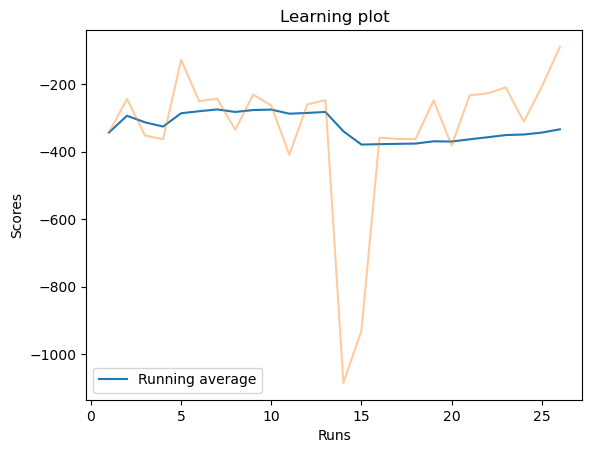

In [5]:
def main():

    random_seed = 0
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    env = Heater()
    env.seed(random_seed)
    
    # Evaluation environment
    eval_env = Heater()
    eval_env.seed(random_seed)

   

    # Hyperparameters
    kwargs = {
        "input_dims": env.observation_space.shape, 
        "actions": env.action_space, 
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "policy_clip": 0.2, 
        "n_epochs": 10, 
        "net_width": 256, 
        "a_lr": 3e-4, 
        "c_lr": 3e-4, 
        "l2_reg": 1e-3, 
        "batch_size": 64, 
        "entropy_coef": 0, 
        "entropy_coef_decay": 0.9998
    }

    N = 2048 # lenth of long trajectory
    max_steps = env.max_time
    Max_train_steps = 25e3
    save_interval = 1e3
    eval_interval = 1e3
    best_interval = 10e3
    render = False

    best_score = -1000


    if not os.path.exists('model'): 
        os.mkdir('model')
    
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    model = PPO(**kwargs)

    
    traj_lenth = 0
    total_steps = 0
    score_history = []
    
    while total_steps < Max_train_steps:
        observation, done, steps, ep_r = env.reset(), False, 0, 0

        '''Interact & trian'''
        while not done:
            traj_lenth += 1
            steps += 1

            if render:
                env.render()
                action_d, action_c = model.evaluate(observation)
                action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }
            else:
                action_d, probs_d, action_c, probs_c = model.select_action(observation)
                action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }

            observation_, reward, done, info = env.step(action)
            model.remember(observation, observation_, action_d, action_c, probs_d, probs_c, reward, done)

            observation = observation_
            ep_r += reward

            '''update if its time'''
            if not render:
                if traj_lenth % N == 0:
                    model.train()
                    traj_lenth = 0
            
            '''record & log'''
            if total_steps % eval_interval == 0:
                score = evaluate_policy(eval_env, model, False, max_steps)
                score_history.append(score)
                print('EnvName: Heater','steps: {}k'.format(int(total_steps/1000)),'score:', score)

            # scheduler.step(score)
            
            total_steps += 1

            '''save model'''
            if total_steps % save_interval==0:
                model.save(total_steps)
            

            ''' best model '''
            if total_steps >= best_interval:
                if score_history[-1] > best_score:
                    best_score = score_history[-1]
                    model.best_save()


    env.close() 
    
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

if __name__ == '__main__':
    main()

### Model testing

In [6]:
# Hyperparameters
env = Heater()
# Hyperparameters
kwargs = {
    "input_dims": env.observation_space.shape, 
    "actions": env.action_space, 
    "gamma": 0.99, 
    "gae_lambda": 0.95, 
    "policy_clip": 0.2, 
    "n_epochs": 10, 
    "net_width": 256, 
    "a_lr": 3e-4, 
    "c_lr": 3e-4, 
    "l2_reg": 1e-3, 
    "batch_size": 64, 
    "entropy_coef": 0, 
    "entropy_coef_decay": 0.9998
}


model = PPO(**kwargs)

model.load_best()
scores = []


for i in range(20):
    obs = env.reset()
    actions = []
    score = 0
    while True:
        action_d, action_c = model.evaluate(obs)
        action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }
        obs, reward, done, info = env.step(action)
        score += reward
        actions.append(action)

        if done:
            print(f"Done, points: {score}")
            break
    
    scores.append(score)

print(f"Mean score: {np.mean(scores)}")



Done, points: -240.56822967529297
Done, points: -290.7319221496582
Done, points: -5.004356384277344
Done, points: -240.56822967529297
Done, points: -302.07711029052734
Done, points: -290.7319221496582
Done, points: -0.21697616577148438
Done, points: -240.56822967529297
Done, points: -262.6412353515625
Done, points: -318.8185272216797
Done, points: -0.21697616577148438
Done, points: -240.56822967529297
Done, points: -5.004356384277344
Done, points: -0.7845344543457031
Done, points: -302.07711029052734
Done, points: -0.7845344543457031
Done, points: -302.07711029052734
Done, points: -5.004356384277344
Done, points: -335.14659118652344
Done, points: -240.56822967529297
Mean score: -181.20793838500975
